In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as op
import networkx as nx
from scipy.sparse import random
from sklearn.datasets import make_sparse_spd_matrix
from scipy.integrate import odeint
import itertools
from sklearn.metrics import mean_squared_error
from jupyterthemes import jtplot
jtplot.style()

In [2]:
class ising:
    
    def __init__(self,J):
        self.J = J
        self.n = self.J.shape[0]
        self.X = np.random.choice([-1,1],self.n)
        self.S = np.zeros((self.n,self.n))
        self.counts = 0
        self.correl_counts = 0
    
    def update(self):
        #self.counts += 1
        i = np.random.randint(0,self.n)
        E = self.X@self.J@self.X
        self.X[i] *= -1
        E_new = self.X@self.J@self.X
        dE = E_new - E
        p = 0.5*(1.0 + np.tanh(E_new-E))
        if np.random.uniform(0,1)>p:
            self.X[i] *= -1
        '''    
        if self.counts%self.n ==0:
            self.correl_counts += 1
            self.S += np.outer(self.X,self.X)   
         '''   
    def getCorrels(self):
        return self.S/self.correl_counts
    

In [3]:
#a matrix of random uniform connections J[ij]
    
N = 7
J = np.zeros((N,N))
for i in range (N):   
    for j in range(i,N):
        
        J[i][j] = J[j][i] = np.random.choice([0,np.random.uniform(0,0.3)],p=[0.5,0.5])
        J[i][i] = 0
#J = np.where(J>0.2,J,0)

In [4]:
np.around(J, decimals = 2)

array([[0.  , 0.  , 0.  , 0.15, 0.  , 0.1 , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.11, 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.14, 0.  , 0.06, 0.06],
       [0.15, 0.  , 0.14, 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.11, 0.  , 0.  , 0.  , 0.1 , 0.  ],
       [0.1 , 0.  , 0.06, 0.  , 0.1 , 0.  , 0.14],
       [0.  , 0.  , 0.06, 0.  , 0.  , 0.14, 0.  ]])

In [5]:
''' Run the ising model with random initial states for 200 steps
M times with the same J matrix and store the configurations in a df
'''
#beta = 2
steps = 10000
# no of configs M
M = 300

configs = []
for i in range(M):
    isingm = ising(J)
    for j in range(steps):
        isingm.update()
    configs.append(isingm.X)
    
df = pd.DataFrame(configs)
df.head()

,0,1,2,3,4,5,6
0,-1,-1,-1,-1,-1,-1,-1
1,-1,-1,-1,-1,-1,-1,-1
2,-1,-1,-1,1,1,1,-1
3,-1,1,1,1,1,1,1
4,-1,1,-1,-1,-1,-1,-1


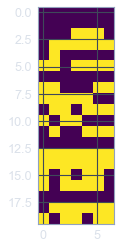

In [6]:
plt.imshow(df[:20])
plt.show()

In [7]:
def av_correls(df):
    n = df.shape[1]
    M = df.shape[0]
    tot_corr = np.zeros((n,n))
    for i in range(M):
        tot_corr += np.outer(df.iloc[i,0:],df.iloc[i,0:])
    return tot_corr/M

C = av_correls(df)
#C = C.clip(min = 0)
np.around(C,2)

array([[ 1.  , -0.01,  0.38,  0.53,  0.09,  0.45,  0.3 ],
       [-0.01,  1.  ,  0.01,  0.02,  0.44,  0.17,  0.11],
       [ 0.38,  0.01,  1.  ,  0.49,  0.19,  0.43,  0.32],
       [ 0.53,  0.02,  0.49,  1.  ,  0.05,  0.33,  0.3 ],
       [ 0.09,  0.44,  0.19,  0.05,  1.  ,  0.39,  0.24],
       [ 0.45,  0.17,  0.43,  0.33,  0.39,  1.  ,  0.54],
       [ 0.3 ,  0.11,  0.32,  0.3 ,  0.24,  0.54,  1.  ]])

In [8]:
np.around(C,2)

array([[ 1.  , -0.01,  0.38,  0.53,  0.09,  0.45,  0.3 ],
       [-0.01,  1.  ,  0.01,  0.02,  0.44,  0.17,  0.11],
       [ 0.38,  0.01,  1.  ,  0.49,  0.19,  0.43,  0.32],
       [ 0.53,  0.02,  0.49,  1.  ,  0.05,  0.33,  0.3 ],
       [ 0.09,  0.44,  0.19,  0.05,  1.  ,  0.39,  0.24],
       [ 0.45,  0.17,  0.43,  0.33,  0.39,  1.  ,  0.54],
       [ 0.3 ,  0.11,  0.32,  0.3 ,  0.24,  0.54,  1.  ]])

no external field, given D configurations sampled by BD, ML per sample is given by 
$$
L_D(J) = \frac{1}{M}\ln p(D|J)=\sum_{i<j} J_{ij}<\sigma_i \sigma_j>^D -\ln Z(J)
$$
where Z is the partition function defined by
$$
Z(J) = \sum_s e^{-H_J(s)}
$$
and H is the Hamiltonian
$$
H_J = - \sum_{i<j} J_{ij}s_i s_j
$$
The sample averages of spin variables and their functions are denoted by
$$
<Q>^D = \frac{1}{M} \sum_{\mu}Q(s^\mu)
$$

1. run metropolis for lots of steps to get data (n samples)

2.
\begin{equation}
\mathcal{L} = \Pi_{k=1}^n f(\underline{s}_k) = \frac{1}{Z}e^{\sum_{ij}J_{ij}s_i^1 s_j^1 + \sum_{ij}J_{ij}s_i^2 s_j^2 + ... } = \frac{1}{Z}e^{\sum_{ij}J_{ij} n <s_is_j>}
\end{equation}
3. Optimise log likelihood 
\begin{equation}
\sum_{ij}J_{ij}<s_i s_j> - lnZ
\end{equation}

In [9]:
sigmas = list(itertools.product([-1,1],repeat = N))

In [10]:
def make_ML(S):
    n = S.shape[0]
    sigmas = list(itertools.product([-1,1],repeat = n))
    def ML(J_list):
        J = J_list.reshape((n,n))
        Z = 0.0
        for s in sigmas:
            Z += np.exp(s@J@s)
        return -(S*J).ravel().sum() + np.log(Z)
    return ML
          

In [11]:
print(J.ravel())
ML = make_ML(C)
x = ML(J.ravel())

[0.         0.         0.         0.15329672 0.         0.1039177
 0.         0.         0.         0.         0.         0.10640332
 0.         0.         0.         0.         0.         0.14183227
 0.         0.06341795 0.05680228 0.15329672 0.         0.14183227
 0.         0.         0.         0.         0.         0.10640332
 0.         0.         0.         0.10432347 0.         0.1039177
 0.         0.06341795 0.         0.10432347 0.         0.13808802
 0.         0.         0.05680228 0.         0.         0.13808802
 0.        ]


In [12]:
J_guess = np.random.uniform(0,0.0,(N,N))
print(J_guess)
MLE = op.minimize(ML,J_guess.ravel())

[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]


In [13]:
J_min =MLE["x"].reshape(N,N) 
print(np.around(0.5*J_min,2))

[[ 0.   -0.02  0.02  0.13 -0.02  0.11  0.  ]
 [-0.02  0.   -0.03  0.02  0.12  0.01  0.  ]
 [ 0.02 -0.03  0.    0.11  0.04  0.07  0.02]
 [ 0.13  0.02  0.11  0.   -0.04 -0.01  0.04]
 [-0.02  0.12  0.04 -0.04  0.    0.11  0.01]
 [ 0.11  0.01  0.07 -0.01  0.11  0.    0.13]
 [ 0.    0.    0.02  0.04  0.01  0.13  0.  ]]


In [14]:
np.around(J,2)

array([[0.  , 0.  , 0.  , 0.15, 0.  , 0.1 , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.11, 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.14, 0.  , 0.06, 0.06],
       [0.15, 0.  , 0.14, 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.11, 0.  , 0.  , 0.  , 0.1 , 0.  ],
       [0.1 , 0.  , 0.06, 0.  , 0.1 , 0.  , 0.14],
       [0.  , 0.  , 0.06, 0.  , 0.  , 0.14, 0.  ]])

In [15]:
mean_squared_error(0.5*J_min,J)

0.00043761808925577104

In [16]:
configs = []
for i in range(M):
    isingm = ising(0.5*J_min)
    for j in range(steps):
        isingm.update()
    configs.append(isingm.X)
    
df2 = pd.DataFrame(configs)
df2.head()

,0,1,2,3,4,5,6
0,-1,-1,-1,-1,-1,-1,-1
1,1,-1,1,1,-1,1,-1
2,-1,-1,1,-1,-1,-1,-1
3,1,1,1,1,1,1,1
4,-1,1,-1,-1,-1,-1,1


In [17]:
C2 = av_correls(df2)
np.around(C2,2)

array([[ 1.  , -0.04,  0.29,  0.49, -0.01,  0.34,  0.21],
       [-0.04,  1.  ,  0.07,  0.02,  0.49,  0.21,  0.15],
       [ 0.29,  0.07,  1.  ,  0.53,  0.15,  0.45,  0.37],
       [ 0.49,  0.02,  0.53,  1.  ,  0.  ,  0.29,  0.23],
       [-0.01,  0.49,  0.15,  0.  ,  1.  ,  0.37,  0.25],
       [ 0.34,  0.21,  0.45,  0.29,  0.37,  1.  ,  0.61],
       [ 0.21,  0.15,  0.37,  0.23,  0.25,  0.61,  1.  ]])

In [18]:
np.around(C,2)

array([[ 1.  , -0.01,  0.38,  0.53,  0.09,  0.45,  0.3 ],
       [-0.01,  1.  ,  0.01,  0.02,  0.44,  0.17,  0.11],
       [ 0.38,  0.01,  1.  ,  0.49,  0.19,  0.43,  0.32],
       [ 0.53,  0.02,  0.49,  1.  ,  0.05,  0.33,  0.3 ],
       [ 0.09,  0.44,  0.19,  0.05,  1.  ,  0.39,  0.24],
       [ 0.45,  0.17,  0.43,  0.33,  0.39,  1.  ,  0.54],
       [ 0.3 ,  0.11,  0.32,  0.3 ,  0.24,  0.54,  1.  ]])

In [19]:
mean_squared_error(0.5*J_min,J)

0.00043761808925577104

In [20]:
mean_squared_error(C,C2)

0.002837188208616779